# Kats 204 Forecasting with Meta Learning


Suppose we have a time series and we are looking to build the best possible forecast (with respect to a predefined error metric such as mean absolute error) from the following list of candidate models (and possibly other forecasting models in Kats too):
* ARIMA
* SARIMA
* Holt-Winters
* Prophet
* Theta
* STLF



For a single time series, it is straightforward to to do hyperparameter tuning for each of the candidate models with this time series, calculate the error metric, and choose the model that minimizes the error metric.  We have discussed this methodology in detail in Kats 201.  Our basic metadata object, `GetMetaData`, which we will introduce below, also does this calculation to find the best forecasting model for a single time series.

However, when we are working with a large number of time series, repeating this process quickly becomes intractable, and for that, we include a meta-learning framework for forecasting.  There are two key model classes, plus one optional one, in our meta-learning framework:

1. `MetaLearnModelSelect`: Given the metadata for a time series, predict the best model family (from the candidate models of interest) to forecast the series.  This model is a random forest by default.
2. `MetaLearnHPT`: Given a time series and a model type, predict the best parameters for this model.  This model is a neutral network.  
3. `MetaLearnPredictability` (optional): Given the metadata for a time series, predict if it is "predictable", i.e. if it is possible to forecast with a threshold error.  This model is a random forest by default.

For each of these models, you can use labeled training data to build a model or you load a pre-trained model from a file path.  

We use the `GetMetaData` object to represent the metadata for a time series in `MetaLearnModelSelect` and `MetaLearnPredictability`.  This tutorial begins with an introduction to the `GetMetaData` object.  Since this object is heavily dependent on `TsFeatures`, if you are not familiar `TsFeatures`, you should check out Kats 203 prior to continuing with this tutorial.  

Next we will use labeled time series data from the `m3_meta_data.csv` file to show how to use the `MetaLearnPredictability`, `MetaLearnModelSelect` and `MetaLearnPredictability`.  


The sample data in `m3_meta_data.csv` is very small, with 78 labeled examples, so the examples we provide here will not be highly accurate, but they will show you the proper workflow for using the meta-learning framework for forecasting in Kats.


The full table of contents for Kats 204 is as follows:
1. Introduction to `GetMetaData`
2. Determining Predictability with `MetaLearnPredictability`
3. Model Selection with `MetaLearnModelSelect`       
4. Hyperparameter Tuning with `MetaLearnHPT`              
    4.1. Initializing `MetaLearnHPT`             
    4.2. `MetaLearnHPT` with Default Neural Network Model Structure      
    4.3. `MetaLearnHPT` with Custom Neural Network Model Structure


## 1. Introduction to `GetMetaData`

The `GetMetaData` class generates the metadata for any time series.  There are three key components to the the metadata for a time series:
1. `features`: the `TsFeatures` dictionary for the time series
2. `hpt_res`: a dictionary giving the best hyperparameters for each candidate model and the corresponding error metric for the time series 
3. `best_model`: the name of the model with the smallest error metric

The default error metric is mean absolute error (mae) but this can be controlled with the `error_method` argument in `GetMetaData`.  

The list of candidate models that we consider is controlled by the `all_models` argument in `GetMetaData`, which is a dictionary with string names of the candidate models as keys and corresponding model classes as value.

with keys equal to the string names of the models as keys  and values equal to the corresponding model class.  The keys in `hpt_res` and the value of `best_model` come from the keys of the `all_models` dictionary.  The default value of `all_models` will include the following six models.

1. ARIMA
2. SARIMA
3. Holt-Winters
4. Prophet`
5. Theta
6. STLF

Our first example uses the `air_passengers` data set.  We show how to get the metadata for this time series.  We start by loading the time series into a `TimeSeriesData` object.

In [1]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore')
sys.path.append("../")

from kats.consts import TimeSeriesData
air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")

air_passengers_df.columns = ["time", "value"]
air_passengers_ts = TimeSeriesData(air_passengers_df)

Now we can construct the `GetMetaData` object for the `air_passengers` data set time series like follows.  We use all of the default settings except that we use mean absolute percentage error (mape) as our error metric rather than the default of mean absolute error (mae) 

In [2]:
from kats.models.metalearner.get_metadata import GetMetaData

# create an object MD of class GetMetaData with error method mean absolute percentage error (mape)
MD = GetMetaData(data=air_passengers_ts, error_method='mape')

Let's take a look at the `all_models` dictionary that is used by default here.  You are allowed to specify your own `all_models` dictionary as long as all the values are classes that extends the abstract class `kats.models.Model`.

In [3]:
MD.all_models

{'arima': kats.models.arima.ARIMAModel,
 'holtwinters': kats.models.holtwinters.HoltWintersModel,
 'prophet': kats.models.prophet.ProphetModel,
 'theta': kats.models.theta.ThetaModel,
 'stlf': kats.models.stlf.STLFModel,
 'sarima': kats.models.sarima.SARIMAModel}

The `all_params` dictionary will have the same keys as the `all_models` dictionary, and the values are the corresponding parameter class (i.e. a class that extends the class `kats.const.Params`)

In [4]:
MD.all_params

{'arima': kats.models.arima.ARIMAParams,
 'holtwinters': kats.models.holtwinters.HoltWintersParams,
 'prophet': kats.models.prophet.ProphetParams,
 'theta': kats.models.theta.ThetaParams,
 'stlf': kats.models.stlf.STLFParams,
 'sarima': kats.models.sarima.SARIMAParams}

Now we can use the `get_meta_data` function to calculate all the metadata and output the result as a dictionary.

In [5]:
# get meta data as a dictionary
air_passengers_metadata = MD.get_meta_data()

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/loc

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning:

No frequency information was provided, so inferred frequency MS w

Let's take a look at the keys of the metadata dictionary.

In [6]:
air_passengers_metadata.keys()

dict_keys(['hpt_res', 'features', 'best_model', 'search_method', 'error_method'])

We explained what `features`, `hpt_res` and `best_model` are above.  This dictionary also includes the `search_method` and `error_method`, which will just be the default values in this case.  We can see these as follows.

In [7]:
print(f"search_method: {air_passengers_metadata['search_method']}")
print(f"error_method: {air_passengers_metadata['error_method']}")

search_method: RandomSearch
error_method: mape


The keys of the `hpt_res` dictionary are name of the candidate model families; they should be the same as the keys for the `all_models` and `all_parameters` dictionaries. 

In [8]:
air_passengers_metadata['hpt_res'].keys()

dict_keys(['arima', 'holtwinters', 'prophet', 'theta', 'stlf', 'sarima'])

The values of the `hpt_res` dictionary are two-element tuples.  The first element is gives the hyperparameters that minimize the error metric.  The second element gives the corresponding minimum error metric.  Let's take a look at these values for ARIMA:

In [9]:
air_passengers_metadata['hpt_res']['arima']

({'p': 4, 'd': 1, 'q': 1}, 0.10648723141588944)

We can sort the different methods by their error metric as follows:

In [10]:
methods = list(air_passengers_metadata['hpt_res'].keys())
sorted(methods, key = lambda m: air_passengers_metadata['hpt_res'][m][1])

['prophet', 'stlf', 'holtwinters', 'sarima', 'theta', 'arima']

This suggests that Prophet has the lowest error metric.  Let's confirm that this is what `best_model` indicates:

In [11]:
air_passengers_metadata['best_model']

'prophet'

We constructed the `GetMetaData` object for the `air_passengers` data set with all of the default settings.  Let's take a look at the full set of attributes that can be used to initialize `GetMetadata`.

This is the only required attributed: 
* **data**: TimeSeriesData, the time series for which we calculate the metadata

The following attributes are all optional:
* **all_models**: `Dict[str, m.Model]`, a dictionary for the candidate model classes.  The key is a string naming the model and each value is a corresponding model class (i.e. a class that extends the abstract class `kats.models.Model`).
* **all_params**: `Dict[str, Params]`, a dictionary for the candidate model parameter classes.  The keys are the same as the keys for `all_models` and each value is a corresponding parameter class (i.e. a class that extends the class `kats.const.Params`).
* **min_length**: int, the minimal length of time series. We raise a value error if the length of `data` is smaller than `min_length`.  The default value of `min_length` is 30.
* **scale**: bool, Whether to rescale the time series by its maximum value; default is true.
* **method**: SearchMethodEnum, Search method for hyper-parameters tuning; default is random search in the default parameter space
* **executor**: Callable, A parallel executor for parallel processing.  By default, we use Python's native multiprocessing implementation.
* **error_method**: str, Type of error metric.  Options are `'mape`', `'smape`',`'mae`', `'mase`', `'mse`', `'rmse`';  default is `'mae'`.
* **num_trials**: int, Number of trials for hyperparameter search; default is 5
* **num_arm**: optional Number of arms in hyperparameter search; default is 4.

For the remaining examples, we use the sample data in `m3_meta_data.csv` to show how to build meta-learning models.  This sample data set contains the metadata for 78 time series, meaning it has that we need to construct 78 metadata dictionaries like the one we constructed for the `air_passengers` data set.  While 78 metadata objects is certainly too few to develop an accurate meta-learning model and you should use more examples for your own meta-learning models to get high accuracy, these examples will help familiarize you with our meta-learning framework.

Loading this data is straightforward is straightforward.  After loading it into a `DataFrame`, we have to do some pre-processing with the `eval` function to ensure that the dictionaries are represented as dictionaries and not as strings.  We demonstrate this as follows:

In [12]:
# load the metadata into a DataFrame
metadata_df = pd.read_csv("../kats/data/m3_meta_data.csv")

# We need to do a little pre-processing to make sure the dictionaries are represented as dictionaries
# rather than as strings.  This function will do that pre-processing.
def change_format(tmp):
    tmp['hpt_res']=eval(tmp['hpt_res'])
    tmp['hpt_res']['sarima'][0]['seasonal_order'] = eval(tmp['hpt_res']['sarima'][0]['seasonal_order'])
    tmp['features']=eval(tmp['features'])
    return tmp

metadata_df = metadata_df.apply(change_format, axis=1)

Let's preview the metadata `DataFrame` we just loaded.

In [13]:
metadata_df.head()

,hpt_res,features,best_model,search_method,error_method,idx
0,"{'arima': ({'p': 5, 'd': 2, 'q': 5}, 0.8932924...","{'length': 68, 'mean': 0.35392156862745106, 'v...",stlf,RandomSearch,mape,N1402
1,"{'arima': ({'p': 5, 'd': 2, 'q': 1}, 0.3989958...","{'length': 68, 'mean': 0.19995256166982928, 'v...",arima,RandomSearch,mape,N1403
2,"{'arima': ({'p': 1, 'd': 2, 'q': 3}, 0.2519500...","{'length': 68, 'mean': 0.48962530217566486, 'v...",holtwinters,RandomSearch,mape,N1404
3,"{'arima': ({'p': 2, 'd': 1, 'q': 3}, 0.3146896...","{'length': 68, 'mean': 0.2980870396939263, 'va...",stlf,RandomSearch,mape,N1405
4,"{'arima': ({'p': 3, 'd': 1, 'q': 1}, 0.1448053...","{'length': 68, 'mean': 0.5336050082683677, 'va...",arima,RandomSearch,mape,N1406


Let's convert this metadata `DataFrame` into a list of metadata dictionaries.

In [14]:
metadata_list = metadata_df.to_dict(orient='records')

## 2. Determining Predictability with `MetaLearnPredictability`

Before using meta-learning models for model selection and hyper-parameter forecasting, we would like to know if our target time series is predictable.  The `MetaLearnPredictability` module allows us to treat this like a binary classification problem and build a model for it.  We train this model using a list of a metadata and a threshold for the error metric.  We use the threshold to label each metadata dictionary as predictable if and only if the error of it's `best_model` is smaller than the input threshold.  The arguments for `MetaLearnPredictability` are as follows:


* **metadata**: A list of dictionaries representing the meta-data of time series (e.g., the meta-data generated by GetMetaData object).  Required unless `load_model=True`.

* **threshold**: Float; the threshold for the forecasting error. A time series whose forecasting error of the best forecasting model is higher than the threshold is considered as unpredictable. Default is 0.2.

* **load_model**: Boolean; whether or not to load a trained model. Default is False.


If we want to train a new predictability model from a list of metadata dictionaries, we should include that list in the `metadata` argument.  If we want to load a trained model, we set `load_data=True` and do ignore the `metadata` argument.  We will provide examples of both below.

For our example, we are going to use the sample metadata from the `m3_meta_data.csv` file to train a predictability model with `MetaLearnPredictability`.  Then we will use this to predict whether or not `air_passenger` time series can be forecasted (with MAPE at most 0.2).

We initialize model using the `metadata_list` we previously generated from `m3_meta_data.csv` as follows:

In [15]:
from kats.models.metalearner.metalearner_predictability import MetaLearnPredictability

# take the time series with MAPE>=0.2 as unpreditable time series and initial the object
mlp=MetaLearnPredictability(metadata_list, threshold=0.2)

When we train the model, we see a dictionary with performance metrics calculated on the test data set.

In [16]:
mlp.train()

{'accuracy': 0.8571428571428571,
 'precision': 0.75,
 'recall': 1.0,
 'f1': 0.8571428571428571}

Now we can use this model to predict if the `air_passenger` time series is predictable.

In [17]:
mlp.pred(air_passengers_ts) 

1

Our prediction is that this model can be forecast with MAPE at most 0.2.

Let's save the model we trained to a file.

In [18]:
mlp.save_model("mlp.pkl")

Now let's re-load our saved model into a new `MetaLearnPredictability` object.

In [19]:
#initiate a new object and load the trained model
mlp2 = MetaLearnPredictability(load_model=True)
mlp2.load_model("mlp.pkl")

Finally, let's use our newly loaded model to repeat the prediction we did on the `air_passenger` data set.

In [20]:
mlp2.pred(air_passengers_ts) 

1

## 3. **Model Selection with `MetaLearnModelSelect`**

The `MetaLearnModelSelect` object allows you to build a predictive model to determine the best forecasting model for a time series.  It is trained using a list of metadata dictionaries.  The arguments for `MetaLearnModelSelect` are as follows:

* **metadata**: A list of dictionaries representing the meta-data of time series (e.g., the meta-data generated by GetMetaData object).  Required unless `load_model=True`.

* **load_model**: Boolean; whether or not to load a trained model. Default is False.

If we want to train a new predictability model from a list of metadata dictionaries, we should include that list in the `metadata` argument.  If we want to load a trained model, we set `load_data=True` and do ignore the `metadata` argument.  We will provide examples of both below.

For our example, we are going to use the sample metadata from the `m3_meta_data.csv` file to train a selection model with `MetaLearnModelSelect`.  Then we will use this to predict the best forecasting model for the `air_passenger` time series.

We initialize model using the `metadata_list` we previously generated from `m3_meta_data.csv` as follows:

In [21]:
from kats.models.metalearner.metalearner_modelselect import MetaLearnModelSelect

#Initialize the MetaLearnModelSelect object
mlms = MetaLearnModelSelect(metadata_list)

Each metadata dictionary includes a `best_model`, and we can take a look at the frquencies of these models using the `count_category` function.

In [22]:
mlms.count_category()

Counter({'stlf': 22,
         'arima': 11,
         'holtwinters': 16,
         'prophet': 7,
         'sarima': 17,
         'theta': 5})

Before we visualize the data and train the model, it is helpful do some preprocessing.  We can do this with the `preprocess` function.

In [23]:
# pre-process the metadata
# don't down-sample it to balance the classes
# standardize the TsFeatures to have zero mean and unit variance
mlms.preprocess(downsample=False, scale=True)

We can see how the different `TsFeatures` in our metadata objects are correlated with each other by plotting a heatmap, which can be generated using the `plot_corr_heatmap` function.

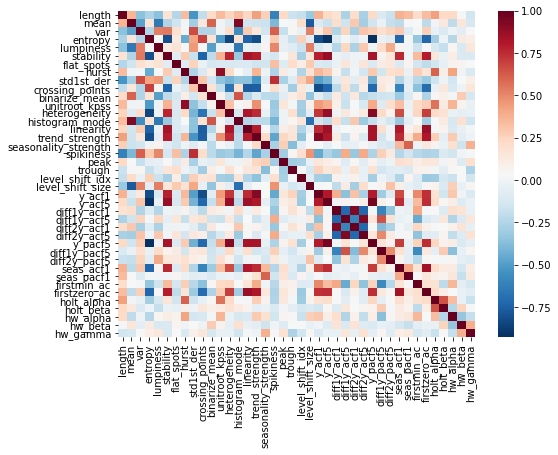

In [24]:
mlms.plot_corr_heatmap()

Now, it is time to train our model.  By default, we will be fitting a random forest model, but other model types (including GBDT, SVT, KNN, Naive Bayes) can be supported using the `method` parameter in the `train` function.  When we run the `train` function, it outputs a dictionary with the training error and test error for each of the candidate models.  All of these error metrics are MAPE because that is the error metric our metadata is using for this example.

In [25]:
# train a modelselect model using random forest algorithm   
results=mlms.train()

# preview the dictionary
results

{'fit_error': {'meta-learn': 0.26309172342253745,
  'stlf': 0.3080445886001993,
  'arima': 0.37093723878018836,
  'holtwinters': 0.34747758968549436,
  'prophet': 0.32925405795892554,
  'sarima': 0.3072710890426296,
  'theta': 0.3490654675305036},
 'pred_error': {'meta-learn': 0.2912143042197297,
  'stlf': 0.30207847656637765,
  'arima': 0.3187864974171871,
  'holtwinters': 0.31852307776283506,
  'prophet': 0.31771750673040133,
  'sarima': 0.28459643367546616,
  'theta': 0.4607974734510193},
 'clf_accuracy': 0.25}

Let's view this dictionary as a `DataFrame`.

In [26]:
results_df=pd.DataFrame([results['fit_error'], results['pred_error']])
results_df['error_type']=['fit_error', 'pred_error']
results_df['error_metric']='MAPE'
results_df

,meta-learn,stlf,arima,holtwinters,prophet,sarima,theta,error_type,error_metric
0,0.263092,0.308045,0.370937,0.347478,0.329254,0.307271,0.349065,fit_error,MAPE
1,0.291214,0.302078,0.318786,0.318523,0.317718,0.284596,0.460797,pred_error,MAPE


Now, let's use our trained model to predict the best model for the `air_passengers` time series.

In [27]:
mlms.pred(air_passengers_ts)

'stlf'

Let's save the model we trained to a file.

In [28]:
mlms.save_model("mlms.pkl")

Now let's re-load our saved model into a new `MetaLearnModelSelect` object.

In [29]:
# TODO: re-run this when the fix has landed
mlms2 = MetaLearnModelSelect(load_model=True)
mlms2.load_model("mlms.pkl")

ValueError: Fail to initiate MetaLearnModelSelect.

Finally, let's use our newly loaded model to repeat the prediction we did on the `air_passenger` data set.

In [30]:
mlms2.pred(air_passengers_ts)

NameError: name 'mlms2' is not defined

## 4. **Hyperparameter Tuning with `MetaLearnHPT`**

The `MetaLearnHPT` object allows you to build a model to predict the best hyperparameters for a time series given a designated forecasting model.  Specifically, `MetaLearnHPT` builds a neural network model that takes the `TsFeatures` for a time series as inputs and predicts the best hyperparameters for the forecasting model.

Since a metadata dictionary contains both the `TsFeatures` and the best parameters (with keys `features` and `hpt_res`, respectively), we can use a list of metadata dictionaries to build this predictive model. 

For our example, we use `metadata_list`, which contains the metadata from the `m3_meta_data.csv` file, to build a  model for the Holt-Winters parameters for a time series.  We then use this model to predict the best Holt-Winters parameters for the `air_passengers` time series.  While this example is using the Holt-Winters model as the designated model, the same process can be used for any forecasting model supported by Kats as long as it is included in our metadata objects.

### 4.1 Initializing `MetaLearnHPT`

To initialize the `MetaLearnHPT` model, we need to input the `TsFeatures` and hyperparameters for the Holt-Winters model as `DataFrame` objects.  To extract these from the metadata from `m3_meta_data.csv`, it is easiest use the `DataFrame` we loaded with this data, `metadata_df`.

First, let's load the `TsFeatures` from `metadata_df` to a new `DataFrame` and preview it.

In [31]:
metadata_features_df = pd.DataFrame(metadata_df['features'].tolist())
metadata_features_df.head()

,length,mean,var,entropy,lumpiness,stability,flat_spots,hurst,std1st_der,crossing_points,...,diff2y_pacf5,seas_acf1,seas_pacf1,firstmin_ac,firstzero_ac,holt_alpha,holt_beta,hw_alpha,hw_beta,hw_gamma
0,68,0.353922,0.045430,0.833179,0.000461,0.011440,2,0.067969,0.138205,32,...,5.088309,0.212199,0.071177,1,12,0.126924,0.000000,2.328909e-01,0.000000e+00,0.186695
1,68,0.199953,0.027798,0.899969,0.000377,0.001403,3,0.031521,0.113224,33,...,1.407981,-0.085866,-0.060512,1,3,0.034220,0.032252,1.052632e-01,1.052632e-01,0.263158
2,68,0.489625,0.045509,0.806731,0.000044,0.014501,2,-0.040535,0.129866,24,...,1.342792,0.173154,-0.019452,2,18,0.044327,0.044327,1.052632e-01,1.052632e-01,0.210526
3,68,0.298087,0.049313,0.667211,0.000149,0.026464,1,0.021439,0.094965,25,...,1.676189,0.330326,-0.217522,3,23,0.000007,0.000000,5.263158e-02,5.263158e-02,0.157895
4,68,0.533605,0.065904,0.823098,0.000124,0.021781,2,-0.045258,0.152166,21,...,1.469424,0.207897,0.014251,2,22,0.000064,0.000000,7.091354e-10,9.692337e-12,0.000000


Now, let's do the same for the the Holt-Winters hyperparameters.

In [32]:
metadata_hpt_df = pd.DataFrame(metadata_df['hpt_res'].map(lambda x: x['holtwinters'][0]).tolist())
metadata_hpt_df.head()

,seasonal_periods,trend,damped,seasonal
0,7,additive,True,multiplicative
1,7,multiplicative,True,multiplicative
2,14,additive,True,additive
3,4,multiplicative,False,multiplicative
4,10,multiplicative,False,additive


The arguments for `MetaLearnHPT` are:
* **data_x**: pd.DataFrame; A DataFrame with the TsFeatures.  Required unless `load_model=True`.
* **data_y**: pd.DataFrame; A DataFrame with the best hyperparameters.  Required unless `load_model=True`.
* **default_model**: string; The name of the forecast model whose default settings will be used. Supported options are 'arima', 'sarima', 'theta', 'prophet', 'holtwinters', 'stlf' and None.  Default is None, in which case we instantiate a custom model and use `categorical_idx` and `numerical_idx` to get the names of the hyperparameters.
* **categorical_idx**: A list of strings of the names of the categorical hyper-parameters.  Required only when `default_model` is `None` and there are categorical hyper-parameters.
* **numerical_idx**: Optional; A list of strings of the names of the numerical hyper-parameters.  Required only when `default_model` is `None` and there are numerical hyper-parameters.
    If None, then a customized model will be initiated.
* **load_model**: Boolean; whether or not to load a trained model. Default is False.


We can initialize the `MetaLearnHPT` model using a `default_model` as follows.

In [33]:
from kats.models.metalearner.metalearner_hpt import MetaLearnHPT

mlhpt_holtwinters = MetaLearnHPT(
    data_x=metadata_features_df,
    data_y=metadata_hpt_df,
    default_model='holtwinters'
)

In [34]:
mlhpt_holtwinters2=MetaLearnHPT(
    data_x=metadata_features_df,
    data_y=metadata_hpt_df,	
    categorical_idx = ["trend","damped","seasonal"],
    numerical_idx = ["seasonal_periods"]
)

### 4.2 `MetaLearnHPT` with Default Neural Network Model Structure

When using a default model like we did when initializing `mlhpt_holtwinters`, `MetaLearnHPT` builds a neural network with the default neural network model structure.  This means we call the `build_network` function with no parameters.

In [35]:
mlhpt_holtwinters.build_network()

Multi-task neural network structure:
MultitaskNet(
  (shared_layer): ModuleList(
    (0): Linear(in_features=40, out_features=20, bias=True)
  )
  (cat_layer_combo): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=20, out_features=2, bias=True)
      (1): Linear(in_features=2, out_features=2, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=20, out_features=3, bias=True)
      (1): Linear(in_features=3, out_features=2, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=20, out_features=5, bias=True)
      (1): Linear(in_features=5, out_features=2, bias=True)
    )
    (3): ModuleList(
      (0): Linear(in_features=20, out_features=3, bias=True)
      (1): Linear(in_features=3, out_features=6, bias=True)
    )
  )
  (num_layer): ModuleList()
)


We use the `train` function to train the neural network.

In [36]:
mlhpt_holtwinters.train(lr=0.001, batch_size=20)

Let's look at the training curves for this model.

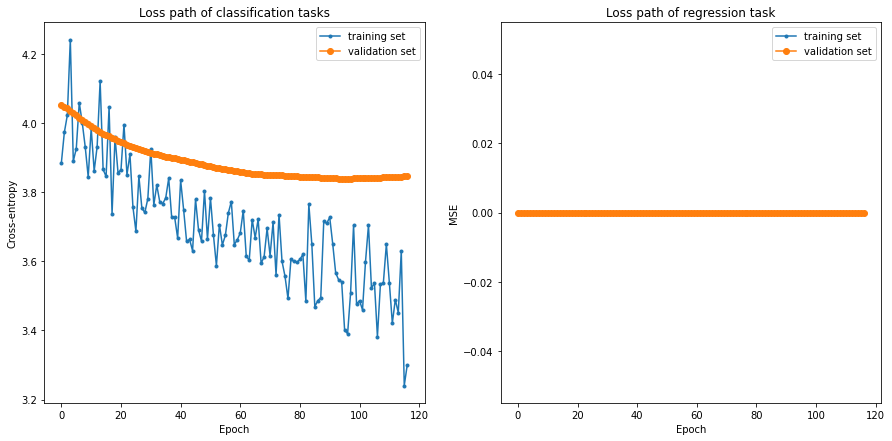

In [37]:
mlhpt_holtwinters.plot()

Now let's use our trained model to predict the best Holt-Winters parameters for the `air_passengers` time series.  The `pred` function returns a `DataFrame` and the predicted parameters are in the `parameters` column.

In [38]:
pred=mlhpt_holtwinters.pred(air_passengers_ts)
pred['parameters'].iloc[0]

{'trend': 'additive',
 'damped': False,
 'seasonal': 'multiplicative',
 'seasonal_periods': 24}

Let's save the model we trained to a file.

In [39]:
mlhpt_holtwinters.save_model("mlhpt_hw.pkl")

Now let's re-load our saved model into a new `MetaLearnHPT` object.

In [40]:
mlhpt_holtwinters3=MetaLearnHPT(load_model=True)
mlhpt_holtwinters3.load_model("mlhpt_hw.pkl")

Let's use our newly loaded model to repeat the prediction we did on the `air_passenger` data set.

In [41]:
pred=mlhpt_holtwinters3.pred(air_passengers_ts)
pred['parameters'].iloc[0]

{'trend': 'additive',
 'damped': False,
 'seasonal': 'multiplicative',
 'seasonal_periods': 24}

### 4.3 `MetaLearnHPT` with Custom Neural Network Model Structure

When using a custom model like we did when initializing `mlhpt_holtwinters2`, you need to specify the model structure by providing the parameters for the neural network to the `build_network` function. 

Here's how we can do that.

In [42]:
mlhpt_holtwinters2.build_network(
    #One shared one-layer NN with 50 neurons.
    n_hidden_shared=[50],
    #Each classification task has its own task-specific NN. In this example, "trend" and "dampled" both have a two-layer NN respectively
    #and "seasonal" has a one-layer NN.
    n_hidden_cat_combo=[[20, 10], [20, 10], [20]], 
    #One task-specific one-layer NN with 30 neurons for regression task.
    n_hidden_num=[30]
)

Multi-task neural network structure:
MultitaskNet(
  (shared_layer): ModuleList(
    (0): Linear(in_features=40, out_features=50, bias=True)
  )
  (cat_layer_combo): ModuleList(
    (0): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
    (1): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=10, bias=True)
      (2): Linear(in_features=10, out_features=2, bias=True)
    )
    (2): ModuleList(
      (0): Linear(in_features=50, out_features=20, bias=True)
      (1): Linear(in_features=20, out_features=2, bias=True)
    )
  )
  (num_layer): ModuleList(
    (0): Linear(in_features=50, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=1, bias=True)
  )
)


Now let's use the `train` function to train the model.  We include some of the extra parameters here to specify how to train the neural network model.

In [43]:
#train the customized NN
mlhpt_holtwinters2.train(    
    #loss_scale is used to balance 2 types of losses: cross-entropy for classification tasks and MSE for regression tasks
    loss_scale=30,
    #learning rate
    lr=0.005,
    n_epochs=2000,
    batch_size=16,
    #supports ADAM and SGD
    method='SGD',
    #momentum in SGD.
    momentum=0,
    #early stop option.
    n_epochs_stop=50,)

Let's look at the training curves for this model.

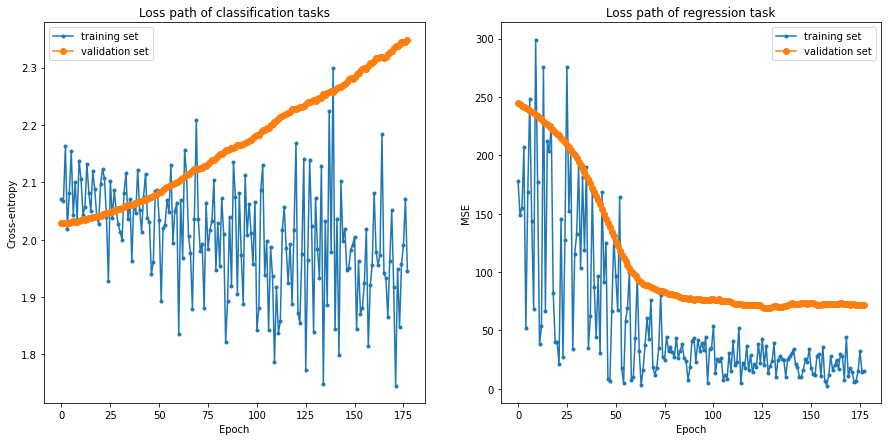

In [44]:
mlhpt_holtwinters2.plot()

Let's use our trained model to predict the best parameters for the `air_passengers` time series. 

In [45]:
pred=mlhpt_holtwinters2.pred(air_passengers_ts)
pred['parameters'].iloc[0]

{'trend': 'additive',
 'damped': False,
 'seasonal': 'multiplicative',
 'seasonal_periods': 134.79474}